IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*


# TD-TME02: les k-plus proches voisins (*k-NN*)

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*Double-cliquer ici et insérer les noms et prénoms de votre binôme*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-02</tt> et rajouter à la suite de <tt>tme-02</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient : <pre>tme-02-Skywalker-Solo</pre>

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-02-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">** à la fin de la séance**</font>. C'est ce compte-rendu qui donne la note de base de la séance.
- vous pouvez éventuellement compléter votre compte-rendu  pour obtenir des points bonus, dans ce cas, vous devez soumettre votre complément avant le début de la semaine suivante.

** Sur la page Moodle de remise du travail <font color="RED">ne pas oublier d'envoyer le compte rendu</font>** à la fin de la séance, la soumission de la version complémentaire post-séance se fera sur une page différente.

## Présentation ##

Dans ce TME, nous allons mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé et programmer les k-NN. Nous allons nous restreindre au cas binaire où les données sont étiquetées $+1$ ou $-1$.


### Objectifs de ce TME 1

Le travail à réaliser est le suivant :
- apprendre à utiliser jupyter notebook
- se documenter sur les structures de données qui seront utilisées pour programmer tout au long du semestre
- implémenter des fonctions pour les mesures vues en cours 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

**Remarque :** La concaténation de vecteurs s'obtient à l'aide de la fonction `vstack` de numpy.

In [2]:
# Exemple d'utilisation de vstack (pour plus de détails, chercher la documentation sur le web)

vecteur_1 = np.array([0, 1.5, 4.2])
vecteur_2 = np.array([1.1, 3.8, 20.01])

vecteur_3 = vecteur_1 + vecteur_2

np.vstack( (vecteur_1, vecteur_2, vecteur_3) )

array([[ 0.  ,  1.5 ,  4.2 ],
       [ 1.1 ,  3.8 , 20.01],
       [ 1.1 ,  5.3 , 24.21]])

### Représentation orientée objets


Pour implémenter nos algorithmes d'apprentissage et pour représenter les données, nous allons utiliser quelques éléments de programmation orientée objet (POO) qu'autorise le langage Python. 

Si vous ne connaissez rien à la POO, il est fortement conseillé de lire une documentation ou suivre un tutorial sur le web (par exemple, http://apprendre-python.com/page-apprendre-programmation-orientee-objet-poo-classes-python-cours-debutants).


## Étape 1: dataset

La première étape consiste à définir une classe, la classe LabelSet, pour stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire.

La classe LabelSet sert donc à stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

**A noter : ** la méthode <tt>\_\_init\_\_</tt> est le constructeur de la classe.


In [3]:
class LabeledSet:  
    """ Classe pour représenter un ensemble d'exemples (base d'apprentissage)
        Variables d'instance :
            - input_dimension (int) : dimension de la description d'un exemple (x)
            - nb_examples (int) : nombre d'exemples dans l'ensemble
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de LabeledSet
            Argument: 
                - intput_dimension (int) : dimension de x
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        """ Ajout d'un exemple dans l'ensemble
            Argument: 
                - vector ()
                - label (int) : classe de l'exemple (+1 ou -1)
            
        """
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    def getInputDimension(self):
        """ Renvoie la dimension de l'espace d'entrée
        """
        return self.input_dimension
    
    def size(self):
        """ Renvoie le nombre d'exemples dans l'ensemble
        """
        return self.nb_examples
    
    def getX(self, i):
        """ Renvoie la description du i-eme exemple (x_i)
        """
        return self.x[i]
    
    #
    def getY(self, i):
        """ Renvoie la classe de du i-eme exemple (y_i)
        """
        return(self.y[i])

In [4]:
# Exemple d'utilisation de LabeledSet

une_base = LabeledSet(2)        # définition d'une base pour contenir des exemples en 2D
une_base.addExample([0, 1],1)   # ajout de l'exemple (0, 1) de classe +1
une_base.addExample([2, 3],1)   # ajout de l'exemple (2, 3) de classe +1
une_base.addExample([1, 2],-1)  # ajout de l'exemple (1, 2) de classe -1
une_base.addExample([2, 2],-1)  # ajout de l'exemple (2, 2) de classe -1


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <tt>affiche_base</tt> qui, étant donné un LabelSet, permet d'afficher tous les exemples qu'il contient.

In [6]:
affiche_base(une_base)

Exemple 0
	description :  [0 1]
	label :  [1]
Exemple 1
	description :  [2 3]
	label :  [1]
Exemple 2
	description :  [1 2]
	label :  [-1]
Exemple 3
	description :  [2 2]
	label :  [-1]


Un dataset en 2 dimensions pourra être affiché en utilisant matplotlib et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    plt.scatter(S_pos[:,0],S_pos[:,1],marker='o') # 'o' pour la classe +1
    plt.scatter(S_neg[:,0],S_neg[:,1],marker='x') # 'x' pour la classe -1


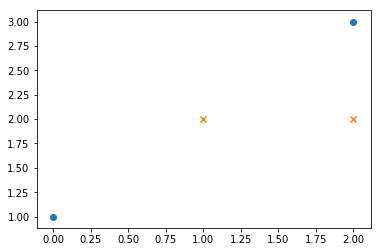

In [8]:
# Par exemple :
plot2DSet(une_base)

### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. 

Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <tt>createGaussianDataset</tt> qui, étant donné 5 arguments:
- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne des points positifs (sous forme de matrice 2*2)
- `negative_center` est le centre de la gaussienne des points négative (vecteur de taille 2)
- `negative_sigma` est la variance de la gaussienne des points négative (sous forme de matrice 2*2)
- `nb_points` est le nombre de points de chaque classe à générer

rend un dataset généré aléatoirement.

Taille de la base jouet générée : 20 exemples


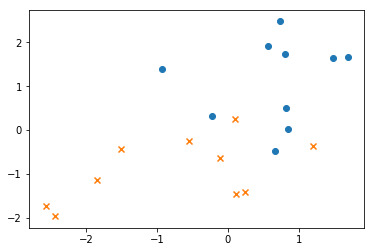

In [10]:
# Exemple d'utilisation:

the_set = createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),10)

print("Taille de la base jouet générée :", the_set.size(), "exemples")

# Affichage :
plot2DSet(the_set)


## Étape 2: les classifieurs

Un classifieur (binaire dans ce cours) permet, pour chaque point d'entrée donné, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. 

Les classifieurs que l'on va implémenter seront définis à l'aide d'une classe qui va dériver de la classe Classifier suivante. Cette classe est une classe "abstraite", elle sera dérivée par héritage pour définir des classifieurs particuliers (knn, arbres de décision, etc.).

Par conséquent, pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle que l'on choisira.

Par contre, la fonction `computeAccuracy` renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant.

<font color="RED" size="+1">**[Q]**</font> Donner l'implémentation de la fonction `computeAccuracy`.

In [ ]:
class Classifier:
    """ Classe pour représenter un classifieur
        Attention: cette classe est une classe abstraite, elle ne peut pas être
        instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
            Hypothèse : input_dimension > 0
        """
        raise NotImplementedError("Please Implement this method")
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        raise NotImplementedError("Please Implement this method")

    def train(self, labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        
        raise NotImplementedError("Please Implement this method")
    
    def accuracy(self, dataset):
        """ Permet de calculer la qualité du système 
        """
        #TODO !!!!

Nous allons maintenant définir un **classifieur linéaire aléatoire** en étendant la classe Classifier et en implémentant le constructeur ainsi que les 2 méthodes `predict` et `train`.

Pour un classifieur linéaire aléatoire:
- dans le constructeur, on doit générer aléatoirement un vecteur $w$ de taille `input_dimension` aléatoirement
- pour ce classifieur, la méthode `train` ne fait rien. On ne mettra qu'un print permettant d'afficher le message "Pas d'apprentissage pour ce classifieur"
- pour une description d'exemple $x$, la méthode `predict` doit utiliser la valeur de $\langle x | w\rangle$ pour prédire le label (+1 ou -1) associé


<font color="RED" size="+1">**[Q]**</font> Donner l'implémentation de la classe ClassifierRandom qui hérite de la classe Classifier et permet de définir un classifieur linéaire aléatoire.

In [ ]:
class ClassifierRandom(Classifier):
    """ Classe pour représenter un classifieur linéaire aléatoire
        Cette classe hérite de la classe Classifier
    """
    
    #TODO: définir le constructeur, et les méthodes predict et train

In [13]:
# Création d'un classifieur linéaire aléatoire de dimension 2:

un_classifieur = ClassifierRandom(2)

<font color="RED" size="+1">**[Q]**</font> Calculer la performance (*accuracy*) d'un classifieur linéaire aléatoire sur un ensemble de 100 points générés aléatoirement.

Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [14]:
def plot_frontiere(set,classifier,step=10):
    """ LabeledSet * Classifier * int -> NoneType
        Remarque: le 3e argument est optionnel et donne la "résolution" du tracé
        affiche la frontière de décision associée au classifieur
    """
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000])

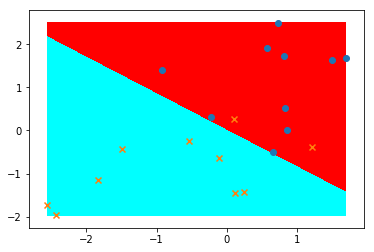

In [15]:
classifieur_random=ClassifierRandom(2)

plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

## Étape 3 : k-NN

De la même façon que nous avons défini un classifieur aléatoire, nosu allons maintenant un classifieur par $k$ plus proches voisins (ou k-NN). 

Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

Pour un classifieur linéaire aléatoire:
- dans le constructeur, on préciser, en plus de la dimension, le nombre de voisins à utiliser (valeur de $k$)
- dans la méthode `train`, on constitue la base de points de référence en mémorisant le LabeledSet donné
- pour une description d'exemple $x$, la méthode `predict` doit construire un tableau de distances aux points de référence, puis le trier grâce à la méthode `numpy.argsort`.


<font color="RED" size="+1">**[Q]**</font> Donner l'implémentation de la classe ClassifierKNN qui hérite de la classe Classifier et permet de définir un classifieur par k-NN.

In [ ]:
class ClassifierKNN(Classifier):
    #TODO

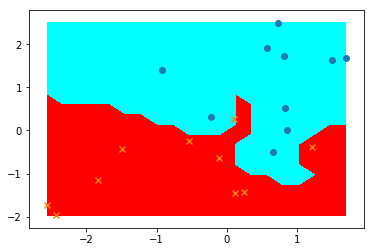

In [17]:
# Exemple d'utilisation :
knn = ClassifierKNN(2,1)
knn.train(the_set)

plot_frontiere(the_set,knn,20)
plot2DSet(the_set) 

## Étape 4: protocole expérimental

Attention, lorsque l'on évalue un classifieur, il est nécessaire de considérer deux ensembles distincts: un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

<font color="RED" size="+1">**[Q]**</font> Donner les instructions permettant d'évaluer un classifieur KNN et comparer les résultats obtenus avec ceux obtenus par un classifieur linéaire aléatoire sur le même jeu de données.

### Différentes expérimentations

<font color="RED" size="+1">**[Q]**</font> Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater ?
Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k.
Essayez avec différentes configurations de gaussiennes.

Accuracy on train 0.500000
Accuracy on test 0.460000


## Étape 5 : données réelles UCI

Plusieurs datasets sont téléchargeables depuis: http://mldata.org

Voir : https://scikit-learn.org/0.19/datasets/mldata.html

Voici la fonction permettant de les charger (en spécifiant leur nom). La fonction se charge de charger les données depuis le web.

In [ ]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
            
loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target

<font color="RED" size="+1">**[Q]**</font> Écrire la fonction `split` permettant de découper un labeledSet données en 2: un ensemble d'apprentissage et un ensemble de test.

<font color="RED" size="+1">**[Q]**</font> Tester différents k-NN , pour différentes valeurs de $k$, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.